<center><h1>Get Data on NHS Waiting Times</h1></center>

<h3>Get urls of all pages with the data</h3>

In [289]:
import requests, sys, webbrowser, bs4, os
import matplotlib.pyplot as plt
import numpy as np
import requests
import pandas as pd
from time import strptime
import matplotlib
import csv
matplotlib.rcParams['mathtext.fontset'] = 'stix'
matplotlib.rcParams['font.family'] = 'sans-serif'
matplotlib.rc('font', size=20)

os.makedirs('AnE_Data', exist_ok=True)

root_url = "https://www.england.nhs.uk/statistics/statistical-work-areas/ae-waiting-times-and-activity/"
res = requests.get(root_url)
soup = bs4.BeautifulSoup(res.content)

linkElems = soup.select("a")
page_names = []

for elem in linkElems:
    if "Monthly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))
    elif "Weekly A&E Attendances and Emergency Admissions" in elem.getText():
        page_names.append(elem.get('href'))

print("Total of {} pages found".format(len(page_names)))

Total of 11 pages found


<h2>Get all csv and xls file names</h2>

In [2]:
csv_file_names = []
xls_file_names = []

for name in page_names:
    #print("Looking at page: ", name, '\n')
    res = requests.get(name)
    soup = bs4.BeautifulSoup(res.content)
    linkElems = soup.select("a")
    for elem in linkElems:
        if '.csv' in elem.get('href'):
            csv_file_names.append(elem.get('href'))
        elif 'AE' in elem.get('href') and '.xls' in elem.get('href'):
            xls_file_names.append(elem.get('href'))
            #print(elem.get('href'))
print("Total of {} csv files and {} xls files.".format(len(csv_file_names), len(xls_file_names)))

Total of 19 csv files and 327 xls files.


<h2>Take data from xls files</h2>

In [257]:
attendence_months = []
over4hours_months = []
period_months = []

attendence_weeks = []
over4hours_weeks = []
period_weeks = []

month_names = ["Janurary", "February","March", "April","May", "June", "July",
          "August", "September", "October", "November", "December"]

def try1(sheet):
    try: over4hours = sheet["Total Attendances > 4 hours"][0]
    except: return False 
    return True

def try2(sheet):
    try: over4hours = attendence - sheet["Total Attendances < 4 hours"][0]
    except: return False 
    return True

def try3(sheet):
    try: over4hours = int((1-sheet["Percentage in 4 hours or less (all)"][0])*attendence)
    except: return False 
    return True


for i, name in enumerate(xls_file_names):
    monthdata = False
    weekdata = False
    resp = requests.get(name)
    
    # Check if data set is for one month or one week
    if 'Quarter' not in name:
        
        tempfile = open('tempfile.xls', 'wb')
        tempfile.write(resp.content)
        tempfile.close()

        #sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A, B, C, D, E, F, G, H, I, J, K")
        
        # I don't think this is how try is supposed to be used but it works
        sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=15, usecols="A,B,C,D,E,F,G,H,I,J,K,L,M, N")
        try:
            attendence = sheet["Total attendances"][0]
        except:
            attendence = sheet["Total Attendances"][0]
        
        if try1(sheet):
            over4hours = sheet["Total Attendances > 4 hours"][0]
        elif try2(sheet):
            over4hours = attendence - sheet["Total Attendances < 4 hours"][0]
        elif try3(sheet):
            over4hours = int((1-sheet["Percentage in 4 hours or less (all)"][0])*attendence)
        
        sheet = pd.read_excel('tempfile.xls', sheet_name=0, skiprows=5, usecols="C")
        period = sheet.columns[0]

        monthdata = False
        weekdata = False
        for month in month_names:
            if month in period and not 'Present' in period:
                monthdata = True
                
        if "Week Ending" in period:
            weekdata = True
            
        if monthdata:
            attendence_months.append(attendence)
            over4hours_months.append(over4hours)
            period_months.append(period)
            if printOutput == True:
                print(period, end = ', ')
        elif weekdata:
            attendence_weeks.append(attendence)
            over4hours_weeks.append(over4hours)
            period_weeks.append(period.split(' ')[2])
            if printOutput == True:
                print(period.split(' ')[2], end = ', ')
        if printOutput == False:
            print("{} complete of {}...".format(i+1,len(xls_file_names)),end = "\r")

In [242]:
def getDate(dateList):
    outList = []
    for date in dateList:
        words = date.split(' ', 1)
        outList.append(float(words[1]) + strptime(words[0][:3],'%b').tm_mon/12)
    return outList

def weekly2monthy(dates, weekly_data, printOutput = False):
    # It's "Week ending <date>" so for each week, if the day is less than 7 
    # I need to give a fraction to the previous month
    days = np.zeros(len(dates))
    months = np.zeros(len(dates))
    years = np.zeros(len(dates))
    
    for i,week in enumerate(dates):
        #print(week)
        split = week.split('/')
        days[i] = int(split[0])
        months[i] = int(split[1])
        years[i] = int(split[2])

    monthly_data = []
    weekly_data = np.asarray(weekly_data)
    
    new_dates = []
    for year in range(int(min(years)),int(max(years))+1):
        for month in range(1, 13):
            mask = (years==year)*(months==month)
            if sum(mask) > 0:
                # Find the data corresponding to this month
                month_data = weekly_data[mask]
                week_ending = days[mask]
                
                # Calculate how much of the data came from the previous month 
                # if this isn't the first data point, give the data to that month
                give_to_pevious = (7-week_ending[-1])*month_data[0]/7
                if len(monthly_data) > 0:
                    monthly_data[-1] += give_to_pevious
                    
                # Calulate total for this month minus donated data
                out = sum(month_data) - give_to_pevious
                # Check that we have all of the data for this month and if we do, append to final data list
                expected_data_entries = np.floor(abs(week_ending[0]-week_ending[-1])/7+1)
                if not int(expected_data_entries) == len(month_data):
                    print("Error! Set: {} \n       Should be {} but it's {}.".format(np.asarray(dates)[mask], 
                                                    expected_data_entries, len(month_data)))
                    print("Set will not be included in final data.")
                else:
                    new_dates.append(year+month/12)
                    monthly_data.append(out)
                    if printOutput == True:
                        print("Month: {} - {} to {}. Total = {}, give_to_previous = {}".format(month,
                                            week_ending[-1], week_ending[0], int(out), int(give_to_pevious)))

    return monthly_data, new_dates

Error! Set: ['30/01/2011' '09/01/2011' '02/01/2011'] 
       Should be 5.0 but it's 3.
Set will not be included in final data.


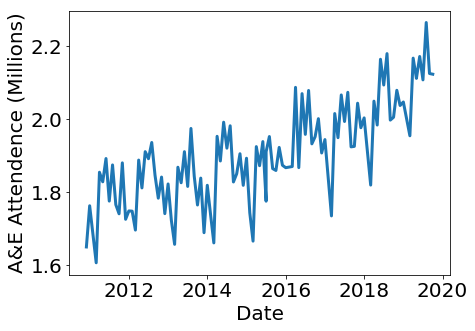

In [283]:
dates = getDate(period_months)
attendence_months2, dates2 = weekly2monthy(period_weeks, attendence_weeks, printOutput=False)

allData = np.concatenate((attendence_months2,attendence_months[::-1]))
allDates = np.concatenate((dates2,dates[::-1]))

plt.figure(figsize = (7,5))

plt.plot(allDates, allData/1e6,lw=3)
plt.ylabel("A&E Attendence (Millions)");
plt.xlabel("Date");

plt.tight_layout()
plt.savefig("AnEattendence.png")

Error! Set: ['30/01/2011' '09/01/2011' '02/01/2011'] 
       Should be 5.0 but it's 3.
Set will not be included in final data.


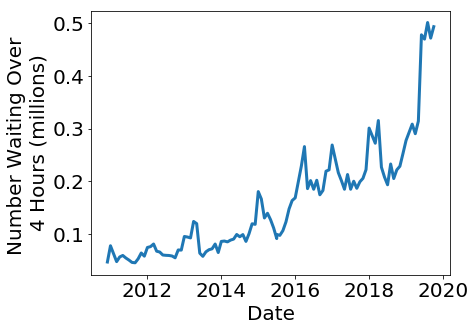

In [284]:
dates = getDate(period_months)
over4hours_months2, dates2 = weekly2monthy(period_weeks, over4hours_weeks, printOutput=False)

allData_over4hours = np.concatenate((over4hours_months2, over4hours_months[::-1]))

allDates = np.concatenate((dates2,dates[::-1]))

plt.figure(figsize = (7,5))

plt.plot(allDates, allData_over4hours/1e6,lw=3)
plt.ylabel("Number Waiting Over \n4 Hours (millions)");
plt.xlabel("Date");
plt.tight_layout()
plt.savefig("Over4Hours.png")

<center><h1>Health Spending</h1></center>

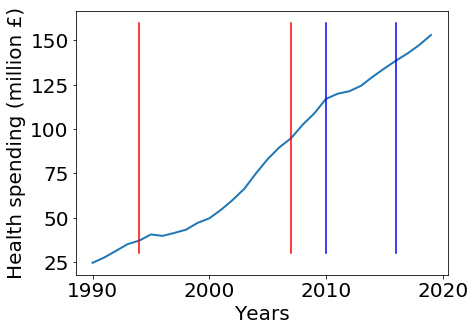

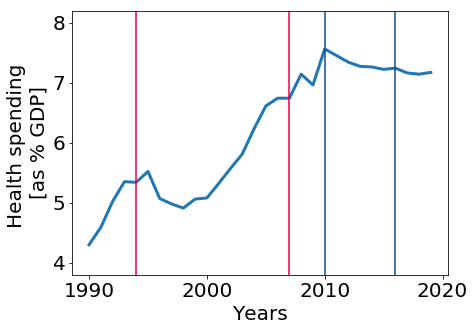

In [297]:
lab_col = "#E4003B"
con_col = "#0D4993"

health = []
years = []
with open("PoliticalData/ukgs_1990_2020.csv") as csvfile:
    readCSV = csv.reader(csvfile)
    row_num = 0
    for row in readCSV:
        if row_num in range(2, 32):
            #print(row_num,row)
            health.append(float(row[3]))
            years.append(int(row[0]))
        row_num += 1
        
health2 = []
years2 = []
with open("PoliticalData/ukgs_1990_2020_GDP.csv") as csvfile:
    readCSV = csv.reader(csvfile)
    row_num = 0
    for row in readCSV:
        if row_num in range(2, 32):
            #print(row_num,row)
            health2.append(float(row[3]))
            years2.append(int(row[0]))
        row_num += 1
plt.figure(figsize = (7,5))
plt.plot(years, health, lw = 2)
plt.ylabel("Health spending (million £)")
plt.xlabel("Years")
# Blair start
plt.plot([1994, 1994], [30, 160],'r')
# Brown start
plt.plot([2007, 2007], [30, 160],'r')
# Cameron start
plt.plot([2010, 2010], [30, 160], 'b')
# May start
plt.plot([2016, 2016], [30, 160], 'b')
plt.tight_layout()
plt.show()

plt.figure(figsize = (7,5))
plt.plot(years2, health2, '-',lw = 3)
plt.ylabel("Health spending \n[as % GDP]")
plt.xlabel("Years")
# Blair start
plt.plot([1994, 1994], [1, 10],'-',color = lab_col)
# Brown start
plt.plot([2007, 2007], [1, 10],'-',color = lab_col)
# Cameron start
plt.plot([2010, 2010], [1, 10], '-',color = con_col)
# May start
plt.plot([2016, 2016], [1, 10], '-',color = con_col)

plt.ylim(3.8, 8.2)
plt.tight_layout()
plt.savefig("spending.png")
plt.show()

<center><h1>Private Operation Numbers</h1></center>

https://www.theguardian.com/society/2019/nov/08/private-surgery-nhs-patients-soars-under-tories?CMP=Share_AndroidApp_WhatsApp&fbclid=IwAR0EIc4TQlyi1JaQmh1wciIFVMlSaq3ty03OEcqgUnyUE5Ia_dc79IEA99U

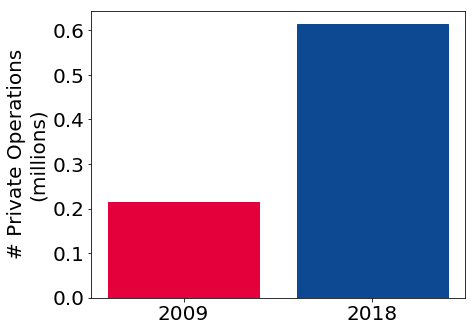

In [293]:
years = [2009, 2018]
priv_ops = np.array([214967,613833])
plt.figure(figsize = (7,5))

barlist =plt.bar(np.arange(2),priv_ops/1e6,tick_label = ['2009','2018'])

plt.ylabel("# Private Operations\n(millions)")

barlist[0].set_color(lab_col)
barlist[1].set_color(con_col)

plt.tight_layout()
plt.savefig("private_operations.png")
plt.show()